In [9]:
from random import uniform
import os
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

In [30]:
class ConvLayer:
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = [[[[uniform(-1, 1) for _ in range(3)] for _ in range(filter_size)] for _ in range(filter_size)] for _ in range(num_filters)]
        
    def iterate_regions(self, image):
        h, w, _ = len(image), len(image[0]), len(image[0][0])
        for i in range(h - self.filter_size + 1):
            for j in range(w - self.filter_size + 1):
                im_region = [[image[i+x][j+y] for y in range(self.filter_size)] for x in range(self.filter_size)]
                yield im_region, i, j

    def forward(self, input):
        self.last_input = input
        h, w, _ = len(input), len(input[0]), len(input[0][0])
        output = [[[0]*self.num_filters for _ in range(w - self.filter_size + 1)] for _ in range(h - self.filter_size + 1)]
        for im_region, i, j in self.iterate_regions(input):
            output[i][j] = [sum(sum(sum(im_region[x][y][z] * self.filters[f][x][y][z] for z in range(3)) for y in range(self.filter_size)) for x in range(self.filter_size)) for f in range(self.num_filters)]
        return output

In [11]:
class MaxPool2:
    def __init__(self, pool_size):
        self.pool_size = pool_size

    def iterate_regions(self, image):
        h, w, _ = len(image), len(image[0]), len(image[0][0])
        new_h = h // self.pool_size
        new_w = w // self.pool_size

        for i in range(new_h):
            for j in range(new_w):
                im_region = [[image[i*self.pool_size+x][j*self.pool_size+y] for y in range(self.pool_size)] for x in range(self.pool_size)]
                yield im_region, i, j

    def forward(self, input):
        self.last_input = input

        h, w, num_filters = len(input), len(input[0]), len(input[0][0])
        output = [[[0]*num_filters for _ in range(w // self.pool_size)] for _ in range(h // self.pool_size)]

        for im_region, i, j in self.iterate_regions(input):
            output[i][j] = [max(max(row)) for row in zip(*im_region)]

        return output

In [12]:
class Flatten:
    def forward(self, input):
        self.last_input_shape = len(input), len(input[0]), len(input[0][0])
        input_flattened = [item for sublist1 in input for sublist2 in sublist1 for item in sublist2]
        self.last_input = input_flattened
        self.total_units = len(input_flattened)  # Store the total number of units
        return input_flattened

In [13]:
class Neuron:
    def __init__(self, num_inputs, activation='relu'):
        self.weights = [uniform(-1, 1) for _ in range(num_inputs)]
        self.bias = uniform(-1, 1)
        self.output = 0
        self.input_sum = 0
        self.activation = activation

    # Sigmoid activation
    def sigmoid(self, x):
        return 1 / (1 + (1 / self.exp(x)))

    # RELU activation
    def relu(self, x):
        return max(0, x)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)
        
    def activate(self):
        if self.activation == 'relu':
            self.output = self.relu(self.input_sum + self.bias)
        elif self.activation == 'sigmoid':
            self.output = self.sigmoid(self.input_sum + self.bias)
        elif self.activation == 'softmax':
            self.output = self.softmax(self.input_sum + self.bias)
        else:
            raise ValueError(f"Unknown activation function: {self.activation}")
            
    # Approximate e^x for activation function
    def exp(self, x):
        n = 1
        sum = 1
        for i in range(1, 100):
            n *= x / i
            sum += n
        return sum

    # Add method for backpropagation
    def backward(self, error, learning_rate):
        
        # Calculate the derivative of the error with respect to the weights and bias
        d_error_d_weights = [error * input for input in self.last_input]
        d_error_d_bias = error

        # Update the weights and bias
        self.weights = [weight - learning_rate * d_error_d_weight for weight, d_error_d_weight in zip(self.weights, d_error_d_weights)]
        self.bias -= learning_rate * d_error_d_bias

In [14]:
class Dropout:
    def __init__(self, rate):
        self.rate = rate

    def forward(self, input):
        self.mask = [uniform(0, 1) > self.rate for _ in range(len(input))]
        return [i * m for i, m in zip(input, self.mask)]

In [15]:
class Layer:
    def __init__(self, num_neurons, num_inputs, activation='relu'):
        self.neurons = [Neuron(num_inputs, activation) for _ in range(num_neurons)]

In [16]:
class Link:
    def __init__(self, source_neuron, target_neuron, weight):
        self.source = source_neuron
        self.target = target_neuron
        self.weight = weight

In [17]:
class LayerLink:
    def __init__(self, source_layer, target_layer):
        self.links = []
        for source_neuron in source_layer.neurons:
            for target_neuron in target_layer.neurons:
                link = Link(source_neuron, target_neuron, 0)
                self.links.append(link)
                target_neuron.weights.append(link.weight)

In [18]:
class Network:
    def __init__(self):
        self.layers = []
        self.layer_links = []

    def add_conv_layer(self, num_filters, filter_size):
        layer = ConvLayer(num_filters, filter_size)
        self.layers.append(layer)

    def add_softmax_layer(self, num_neurons, num_inputs):
        layer = Layer(num_neurons, num_inputs, activation='softmax')
        self.layers.append(layer)

    # Approximate log(x) for the loss function
    def log(self, x):
        n = 50  # the higher n is, the more accurate the approximation
        return n * (x ** (1/n) - 1)
        
    def cross_entropy_loss(self, outputs, targets):
        # Number of samples
        N = len(targets)
    
        # Calculate the cross entropy
        loss = -sum(target * self.log(output) for target, output in zip(targets, outputs)) / N
    
        return loss
        
    def initialize_weights_randomly(self):
        for layer_link in self.layer_links:
            for link in layer_link.links:
                link.weight = self.random()

    def initialize_network_from_file(self, filename):
        with open(filename, 'r') as f:
            num_layers = int(f.readline().strip())  # Read the number of layers
            print(f"Number of layers: {num_layers}")

            layer_sizes = [int(f.readline().strip()) for _ in range(num_layers)]  # Read the layer sizes
            print("Number of neurons in each layer:")

            for i, size in enumerate(layer_sizes):
                print(f"Layer {i+1}: {size} neuron(s)")

            input_size = layer_sizes[0]
            for size in layer_sizes[1:]:
                self.layers.append(Layer(size, input_size))
                input_size = size

            self.layer_links = []
            for i in range(len(self.layers) - 1):
                layer_link = LayerLink(self.layers[i], self.layers[i + 1])
                self.layer_links.append(layer_link)

    def feedforward(self, inputs):
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Layer):
                next_inputs = []
                for neuron in layer.neurons:
                    neuron.input_sum = sum(w * i for w, i in zip(neuron.weights, inputs))
                    neuron.activate()
                    next_inputs.append(neuron.output)
                inputs = next_inputs
            elif isinstance(layer, ConvLayer) or isinstance(layer, MaxPool2) or isinstance(layer, Flatten):
                inputs = layer.forward(inputs)
            else:
                raise TypeError("Unsupported layer type")
        return inputs


    def train(self, inputs, targets, num_epochs, learning_rate):
        for epoch in range(num_epochs):
            for input, target in zip(inputs, targets):
                # Forward pass
                outputs = self.feedforward(input)

                # Calculate the error
                error = self.cross_entropy_loss(outputs, target)

                # Backward pass
                for layer in reversed(self.layers):
                    error = layer.backward(error, learning_rate)

In [19]:
#########################################################################

In [20]:
def custom_cnn_model():
    # Define the CNN model
    network = Network()

    network.add_conv_layer(32, 3)
    network.layers.append(MaxPool2(2))
    network.add_conv_layer(64, 3)
    network.layers.append(MaxPool2(2))
    network.add_conv_layer(128, 3)
    network.layers.append(MaxPool2(2))
    flatten_layer = Flatten()
    # Create a dummy input manually
    dummy_input = [[[0]*128 for _ in range(204//8)] for _ in range(153//8)]
    flatten_layer.forward(dummy_input)  # This will set flatten_layer.total_units
    network.layers.append(flatten_layer)
    network.layers.append(Layer(128, flatten_layer.total_units))  # Now this should work
    network.layers.append(Dropout(0.1))
    network.layers.append(Layer(3, 128))

    return network



In [21]:
#########################################################################

In [ ]:
# !gdown "1WceM5HuxdSiQBzMvhLdKZH88xohgCXaw"
# !gdown "19YfHt_7cdSePo6KLSCmJthWLKRVxJKLw"
# !gdown "1hmOBV7fIEgsmLFaHv5r-GSQuQfHCWPUP"
# !unzip shoe_sandal_boot.zip
!unzip "Flower Image Dataset.zip"
!unzip "Intel Image Classification.zip"

Archive:  Flower Image Dataset.zip
  inflating: flowers/bougainvillea_00002.jpg  
  inflating: flowers/bougainvillea_00003.jpg  
  inflating: flowers/bougainvillea_00004.jpg  
  inflating: flowers/bougainvillea_00005.jpg  
  inflating: flowers/bougainvillea_00006.jpg  
  inflating: flowers/bougainvillea_00007.jpg  
  inflating: flowers/bougainvillea_00008.jpg  
  inflating: flowers/bougainvillea_00009.jpg  
  inflating: flowers/bougainvillea_00010.jpg  
  inflating: flowers/bougainvillea_00012.jpg  
  inflating: flowers/bougainvillea_00013.jpg  
  inflating: flowers/bougainvillea_00014.jpg  
  inflating: flowers/bougainvillea_00015.jpg  
  inflating: flowers/bougainvillea_00016.jpg  
  inflating: flowers/bougainvillea_00017.jpg  
  inflating: flowers/bougainvillea_00018.jpg  
  inflating: flowers/bougainvillea_00019.jpg  
  inflating: flowers/bougainvillea_00020.jpg  
  inflating: flowers/bougainvillea_00021.jpg  
  inflating: flowers/bougainvillea_00022.jpg  
  inflating: flowers/boug

(102, 136, 3)


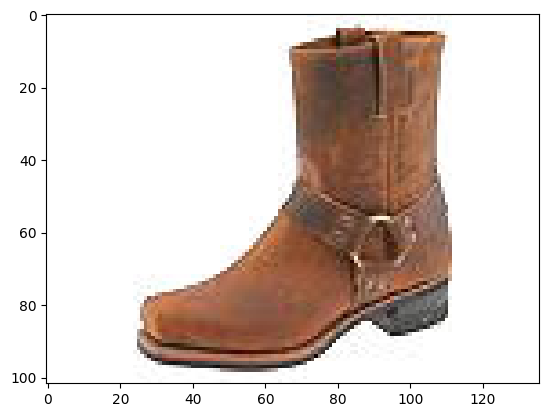

In [23]:
img = cv2.imread(f'Shoe vs Sandal vs Boot Dataset/Boot/boot (1).jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)
del img

In [24]:
# Path to image folder
data_dir = "Shoe vs Sandal vs Boot Dataset/"
data_shoe = data_dir + "Shoe/"
data_sandal = data_dir + "Sandal/"
data_boot = data_dir + "Boot/"

# Type of images
shoe = "Shoe"
sandal = "Sandal"
boot = "boot"

# Get all image file paths
shoe_images = [os.path.join(data_shoe, filename) for filename in os.listdir(data_shoe)]
sandal_images = [os.path.join(data_sandal, filename) for filename in os.listdir(data_sandal)]
boot_images = [os.path.join(data_boot, filename) for filename in os.listdir(data_boot)]

print(len(shoe_images))
print(len(sandal_images))
print(len(boot_images))

5000
5000
5000


In [25]:
def load_images(all_images, data_path, data_type):
    images = []
    for index in range(1, len(all_images) + 1):
        img = cv2.imread(f"{data_path}{data_type} ({index}).jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (204, 153))
        images.append(img)
    return images

shoe_data = load_images(shoe_images, data_shoe, shoe)
sandal_data = load_images(sandal_images, data_sandal, sandal)
boot_data = load_images(boot_images, data_boot, boot)
# images = train_images
print(len(shoe_data))
print(len(sandal_data))
print(len(boot_data))

5000
5000
5000


In [26]:
print(boot_data[500].shape)

(153, 204, 3)


In [27]:
def split_data(data, test_size=0.2, random_seed=42):
    # Set the random seed for reproducibility
    random.seed(random_seed)

    # Shuffle the data
    random.shuffle(data)

    # Calculate the index at which to split the data
    split_idx = int(len(data) * (1 - test_size))

    # Split the data into training and testing sets
    train_data = data[:split_idx]
    test_data = data[split_idx:]

    return train_data, test_data

# Define the validation split
validation_split = 0.2

# Split each class into training and testing sets
shoe_train, shoe_test = split_data(shoe_data, test_size=validation_split)
sandal_train, sandal_test = split_data(sandal_data, test_size=validation_split)
boot_train, boot_test = split_data(boot_data, test_size=validation_split)

# Concatenate the training sets and the testing sets separately
X_train = shoe_train + sandal_train + boot_train
X_test = shoe_test + sandal_test + boot_test

# Create labels for the training and testing sets
y_train = [0]*len(shoe_train) + [1]*len(sandal_train) + [2]*len(boot_train)  # 0 for shoe, 1 for sandal, 2 for boot
y_test = [0]*len(shoe_test) + [1]*len(sandal_test) + [2]*len(boot_test)


In [28]:
class Trainer:
    def __init__(self, network, num_epochs, learning_rate, loss_threshold, patience):
        self.network = network
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.loss_threshold = loss_threshold
        self.patience = patience

    def train(self, train_images, train_labels):
        best_loss = float('inf')
        patience_cnt = 0

        for epoch in range(self.num_epochs):
            correct_cnt = 0
            start_time = time.time()

            for i, image in enumerate(train_images):
                # Forward pass and calculate the loss
                output = self.network.feedforward(image)
                loss = self.network.cross_entropy_loss(output, train_labels[i])

                # Backward pass and update weights
                self.network.train(image, train_labels[i], self.learning_rate)

                # Calculate the number of correct predictions
                if np.argmax(output) == np.argmax(train_labels[i]):
                    correct_cnt += 1

            # Calculate the accuracy
            accuracy = correct_cnt / len(train_images)

            # Print the results for this epoch
            print(f"Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}, Time: {time.time() - start_time}s")

            # Check if the loss has improved
            if loss < best_loss:
                best_loss = loss
                patience_cnt = 0  # Reset patience counter
            else:
                patience_cnt += 1  # Increment patience counter

            # Check if the loss is less than the threshold
            if loss < self.loss_threshold:
                print("Early stopping due to loss threshold being reached")
                break

            # Check if patience counter has reached its limit
            if patience_cnt >= self.patience:
                print("Early stopping due to loss not improving")
                break


In [31]:
# Initialize your model
network = custom_cnn_model()

# Initialize your trainer
trainer = Trainer(network, num_epochs=10, learning_rate=0.01, loss_threshold=0.01, patience=5)

# Train your model
trainer.train(X_train, y_train)

IndexError: list index out of range